# Classificació de senyals de trànsit amb LeNet-5 
by **Bruna da Silva**

---
## Pas 0: Importa les llibreries i les dades
Importem algunes de les llibreries que necessitem per aquest projecte.

In [3]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

Prenem les dades, és a dir, les imatges que hem descarregat i que es troben a la carpeta 'training'. Emmagatzemarem les imatges en una llista ("images") i les seves etiquetes corresponents en una altra ("labels"). 

In [4]:
images = [] 
labels = [] 
classes = 43 # Tenim 43 categories per classificar les imatges

current_path = 'training/'

for i in range(classes):
    path = os.path.join(current_path, str(str(i).zfill(5))) # Construim les rutes de les carpetes de cada classe
    img_folder = os.listdir(path)
    for j in img_folder:
        try:
            image = cv.imread(str(path+'/'+j))
            image = cv.resize(image, (32, 32))              # Redimensionem les imatges a 32x32 px
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)    # Convertim la imatge del format BGR (el format per defecte d'OpenCV) a RGB.
            image = np.array(image)     # Convertim la imatge en un array de NumPy, per facilitar la manipulació de dades.
            images.append(image)        # Afegim la imatge a la llista
            label = np.zeros(classes)   # Creem l'etiqueta per la classe
            label[i] = 1.0
            labels.append(label)        # Afegim l'etiqueta a la llista
        except:
            pass

images = np.array(images)
labels = np.array(labels) # Convertim les llistes en un array de NumPy, per poder utilitzar-lo fàcilment en un model de machine learning.

---
## Pas 1: Exploració i resum de les dades

### 1. Divisió de les dades
Del dataset sencer, un 75% de les dades seran d'**entrenament**, un 15% de **validació**, i un 10% de **test**. 

Primer convertirem l'array "images" a un tipus de dades int16 (números enters de 16 bits) i el "labels" a un float32 (números en coma flotant de 32 bits). Això pot ser útil per optimitzar l'ús de memòria o per ajustar el tipus de dades als requisits del model.

In [5]:
X = images.astype(np.int16)     
y = labels.astype(np.float32)

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=123) # Dividim les dades en dos conjunts: un d'entrenament i un altre de prova 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=123) # Dividim el conjunt de prova en un de validació i un altre de prova definitiu

# Imprimim la forma dels diferents conjunts de dades (nombre d'imatges, alçada, amplada, canals de color)
# Imprimim la forma dels diferents conjunts d'etiquetes (nombre d'etiquetes, nombre de classes)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (19980, 32, 32, 3)
y_train shape: (19980, 43)
X_valid shape: (3996, 32, 32, 3)
y_valid shape: (3996, 43)
X_test shape: (2664, 32, 32, 3)
y_test shape: (2664, 43)


### 2. Resum bàsic del dataset
Obtenim informació del dataset.

In [30]:
# Nombre d'exemples d'entrenament
n_train = X_train.shape[0]

# Nombre d'exemples de validació
n_validation = X_valid.shape[0]

# Nombre d'exemples de prova
n_test = X_test.shape[0]

# La mida de les imatges
image_shape = X_train.shape[1:4]

# Quantes classes úniques, o etiquetes, hi ha
n_classes = np.unique(ar=y_train).shape[0]

# La profunditat de color de les imatges (el nombre de canals)
image_depth_dimension = X_train.shape[3]

print("Nombre d'exemples d'entrenament =", n_train)
print("Nombre d'exemples de validació =", n_validation)
print("Nombre d'exemples de prova =", n_test)
print("Mida de les imatges =", image_shape)
print("Nombre de classes =", n_classes)

Nombre d'exemples d'entrenament = 19980
Nombre d'exemples de validació = 3996
Nombre d'exemples de prova = 2664
Mida de les imatges = (32, 32, 3)
Nombre de classes = 2


Les imatges són de 32x32x3, és a dir, imatges en color d'una resolució molt baixa. A partir d'algunes escollides a l'atzar podem observar com són les imatges del dataset.

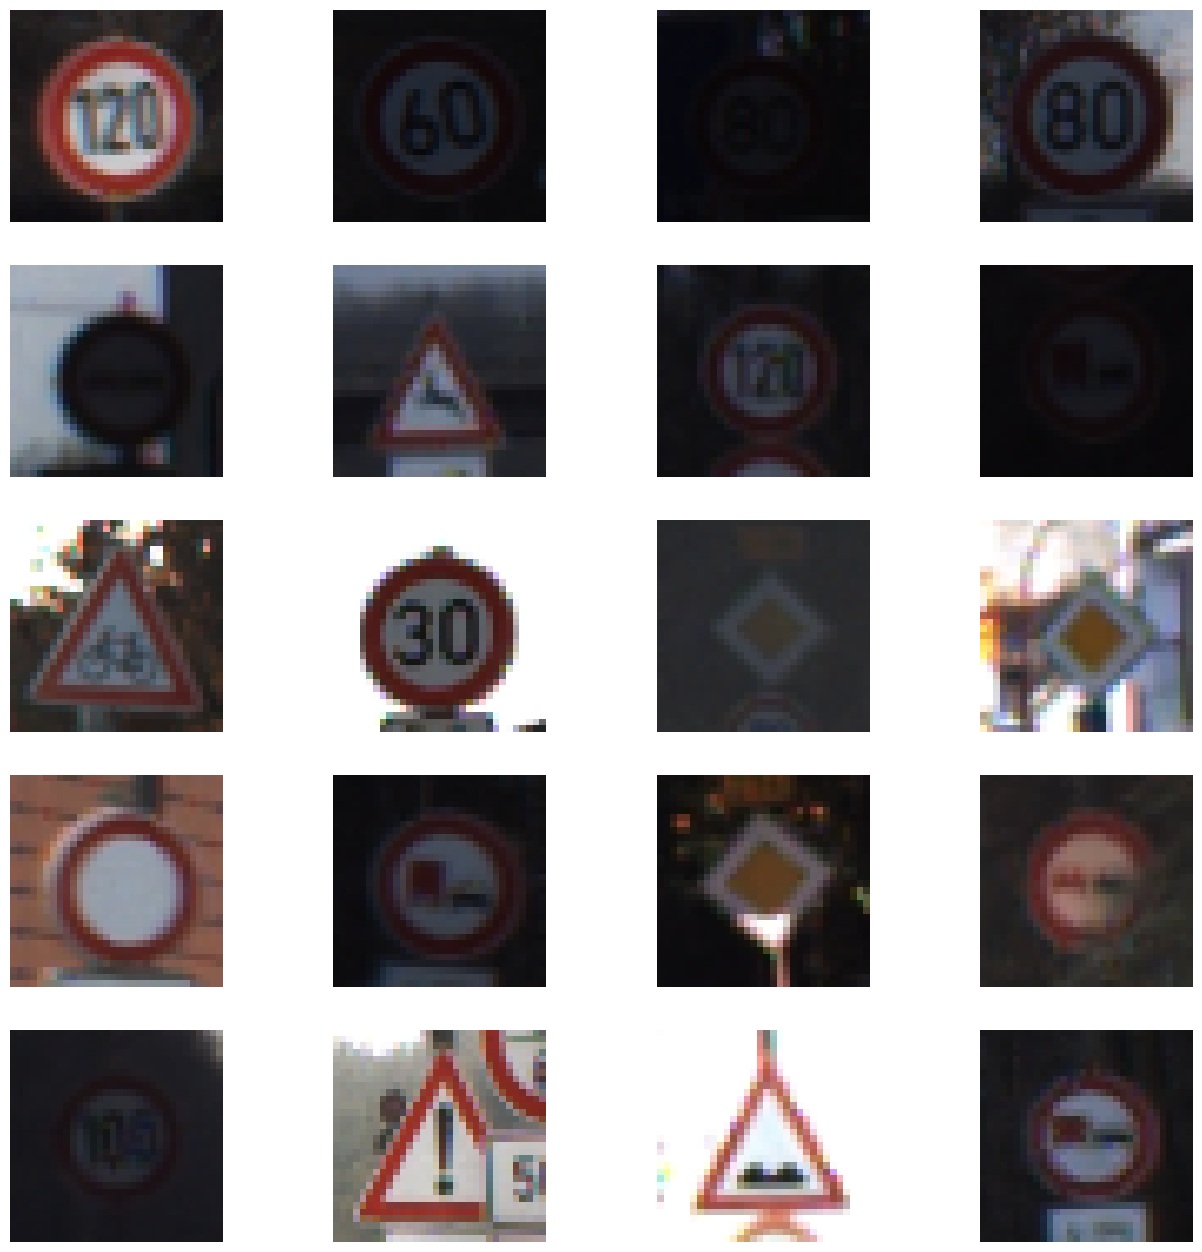

In [7]:
import matplotlib.pyplot as plt
from random import randint

fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5    # Mostrarem 20 imatges a l'atzar en una graella

for i in range(1, columns*rows +1):
    # Mostrem imatges del dataset a l'atzar 
    img = X_train[randint(0, n_train-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')   
plt.show()

---
## Pas 2: Preprocessament de les imatges

### 1. Normalització

In [8]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [length, width, color_depth]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

# Creem uns arrays per cada conjunt de dades on emmagatzemar les imatges normalitzades:
normalized_train = np.zeros([n_train,32,32,3])
normalized_validation = np.zeros([n_validation,32,32,3])
normalized_test = np.zeros([n_test,32,32,3])

# Comprovem que les dimensions de les dades normalitzades són les mateixes que les originals:
for i in range(0,n_train):
    normalized_train[i] = normalize(X_train[i])
for i in range(0,n_validation):
    normalized_validation[i] = normalize(X_valid[i])
for i in range(0,n_test):
    normalized_test[i] = normalize(X_test[i])

assert(X_train.shape==normalized_train.shape)

### 2. Mostrem la diferència que marca la normalització

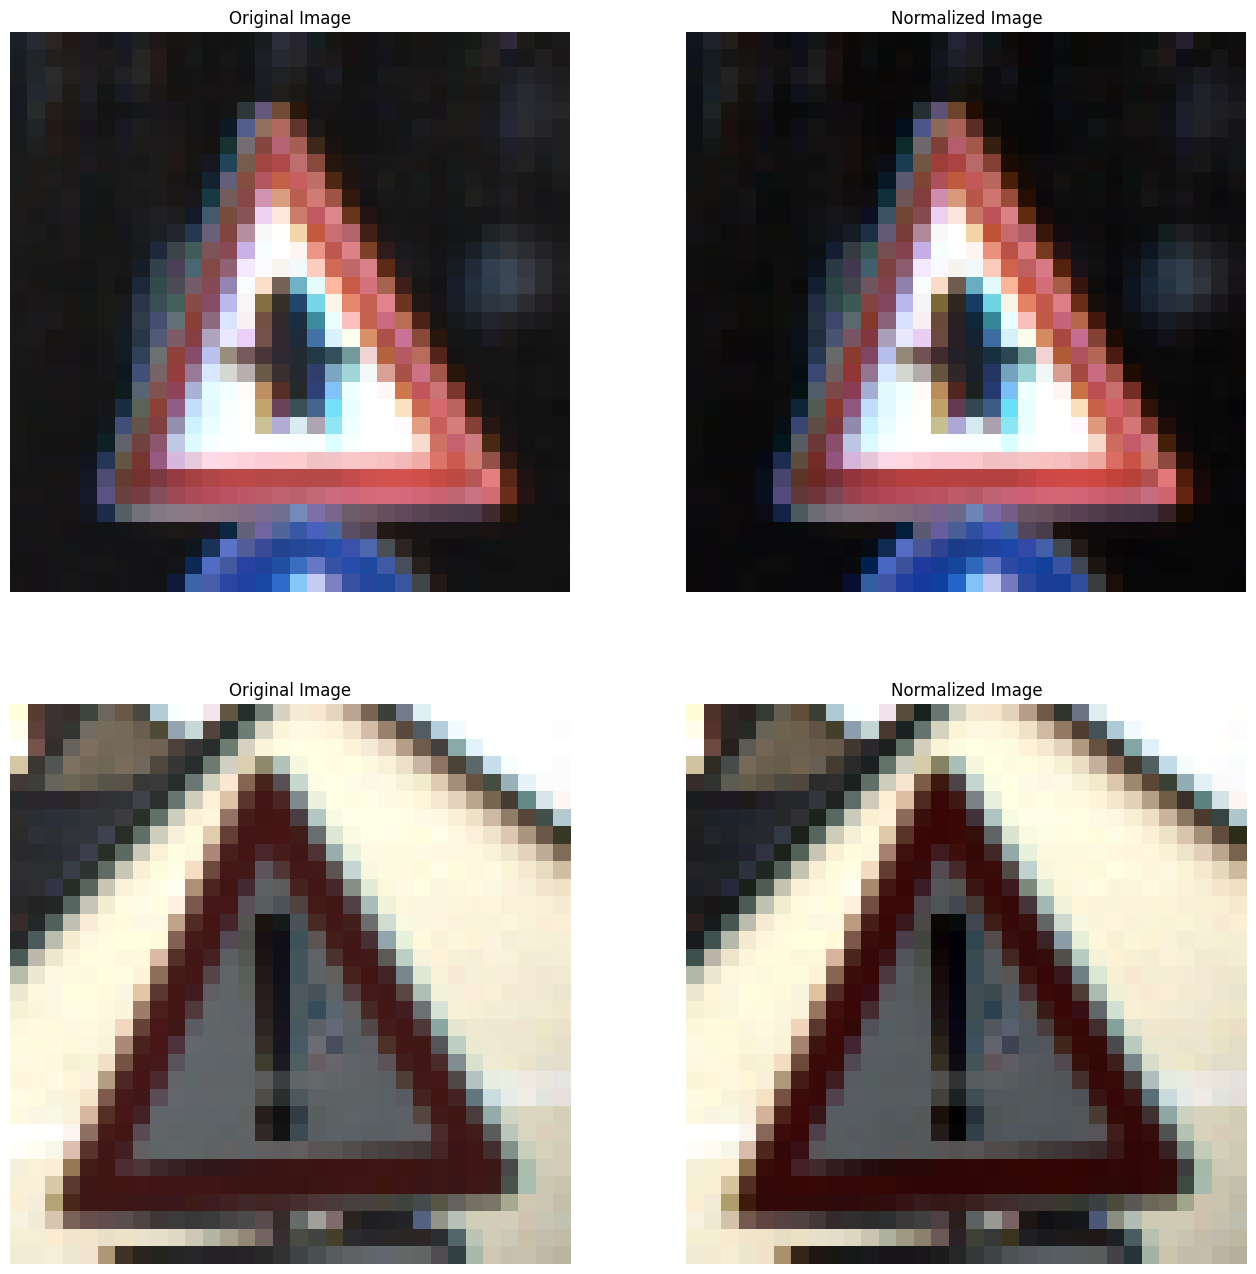

In [9]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16)) # Mostrarem 2 imatges a l'atzar junt amb la seva normalització en una graella
randomindex = randint(0,n_train-1)
axarr[0,0].imshow(X_train[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original Image')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Normalized Image')
randomindex = randint(0,n_train-1)
axarr[1,0].imshow(X_train[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Original Image')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Normalized Image')

plt.show()

### 3. Fem que les imatges normalitzades siguin les que es facin servir 

Substituim els diferents conjunts d'imatges no preprocessades pels nous conjunts d'imatges normalitzades per utilitzar-les dins el nostre model.

In [10]:
X_train = normalized_train

X_valid = normalized_validation

X_test = normalized_test

---
## Pas 3: Construim el model

Creem un **model seqüencial** que conté les capes afegides dins dels claudàtors [ ... ]. Cada capa s'aplica en l'ordre en què es defineix. Afegirem els tipus de capes següents:
- **Rescaling**: Reescala els valors de píxels de les imatges d'entrada. Aquí, "Rescaling(1, ...) no canvia els valors.

- **Conv2D**: Afegeix una [capa convolucional](https://www.ibm.com/topics/convolutional-neural-networks) amb X filtres de mida 5x5. Aquesta capa detecta característiques bàsiques a les imatges, com vores i textures.

- **AveragePooling2D**: Aplica un [pool mitjà](https://www.ibm.com/topics/convolutional-neural-networks) amb una finestra de 2x2 píxels , reduint la mida espacial de l'entrada.

- **Dropout**: Afegeix una capa de Dropout que desactiva aleatòriament el 20% de les neurones durant l'entrenament per evitar el [sobreajustament  o overfitting](https://www.ibm.com/es-es/topics/overfitting).

- **Flatten**: Aplana la sortida de les capes anteriors en un vector unidimensional, preparant-lo per a la capa totalment connectada (fully connected, FC)).

- **Dense**(units=120, activation='relu'): Afegeix una capa FC amb 120 neurones.

- **Dense**(units=43, activation='softmax'): Afegeix la capa de sortida amb 43 neurones, que correspon al nombre de classes. La funció d'activació softmax converteix les sortides en probabilitats.

In [11]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Rescaling, AveragePooling2D, Dropout

model = Sequential([    

    Rescaling(1, input_shape=(32, 32, 3)),  
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(filters=120, kernel_size=(5, 5), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=43, activation='softmax')
])

# Compilació del model:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrem un resum de l'arquitectura del model:
model.summary()

2024-09-08 10:09:46.848103: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 10:09:47.000335: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 10:09:47.149242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 10:09:47.283398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 10:09:47.311381: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 10:09:47.548806: I tensorflow/core/platform/cpu_feature_gu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        14,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,203 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,715 (276.23 KB)

 Trainable params: 70,715 (276.23 KB)

 Non-trainable params: 0 (0.00 B)

---
## Pas 4: Entrenem el model

In [12]:
# L'entrenem
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

# Guardem el model a la carpeta "model"
model.save('./model/lenet.keras')


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3112 - loss: 2.5764 - val_accuracy: 0.8473 - val_loss: 0.5616
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8144 - loss: 0.6032 - val_accuracy: 0.9224 - val_loss: 0.2984
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8972 - loss: 0.3395 - val_accuracy: 0.9550 - val_loss: 0.1880
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9264 - loss: 0.2485 - val_accuracy: 0.9517 - val_loss: 0.1785
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9441 - loss: 0.1883 - val_accuracy: 0.9695 - val_loss: 0.1328
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9512 - loss: 0.1563 - val_accuracy: 0.9777 - val_loss: 0.1081
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9573 - loss: 0.1331 - val_accuracy: 0.9755 - val_loss: 0.1142
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9623 - loss: 0.1132 - val_accuracy: 0.

---
## Pas 5: Avaluem

Un cop entrenat el model, l'avaluem amb diferents tipus de gràfics, que ens permeten veure el seu rendiment des de diferents perspectives:

- [**Confusion matrix**](https://developers.google.com/machine-learning/crash-course/classification/thresholding#confusion_matrix): Ens mostra els diferents tipus de resultats que s'han donat en cada classe ([True Positive, False Positive, True Negative, False Negative](https://chatgpt.com/share/24a352dd-7ad1-4a3a-97f9-78a43757c1ed)) de manera visual.

- [**Accuracy**](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#accuracy): Mesura la proporció de prediccions correctes fetes pel model (TP i TN) sobre totes les prediccions: Accuracy = TP+TN / PrediccionsTotals

- [**Loss**](https://developers.google.com/machine-learning/crash-course/linear-regression/loss): Quantifica l’error entre les prediccions del model i els valors reals. Un “loss” més baix indica un millor rendiment del model.

In [13]:
model = load_model('./model/lenet.keras') # Carreguem el model

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


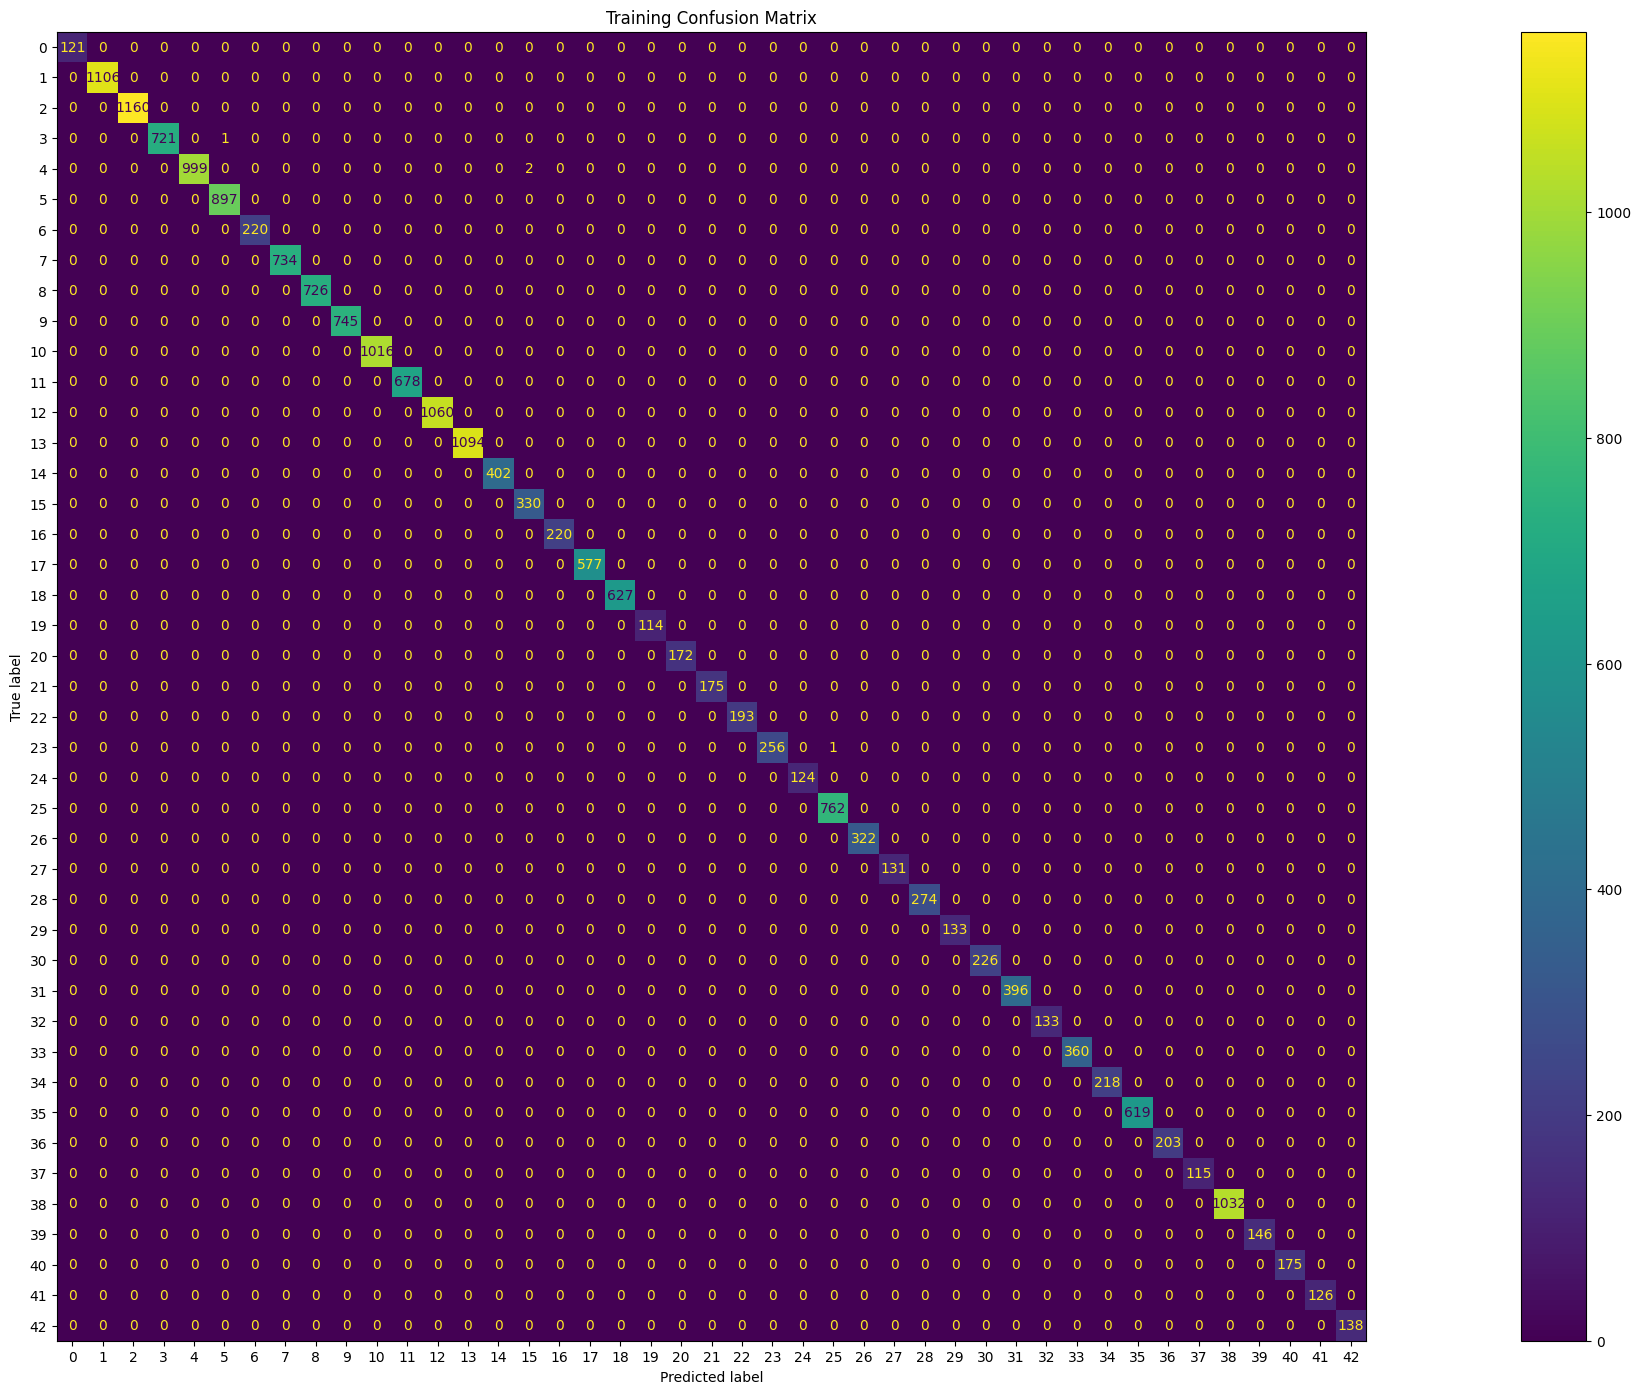

In [28]:
# Confusion matrix de l'entrenament

import seaborn as sns
from sklearn import metrics

predict_xTrain = model.predict(X_train)
classes_xTrain = np.argmax(predict_xTrain,axis=1)
yTrain_true = np.argmax(y_train, axis=1)

train_confusion_matrix = metrics.confusion_matrix(yTrain_true, classes_xTrain)

train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = train_confusion_matrix)

fig, ax = plt.subplots(figsize=(40, 17)) 
train_cm_display.plot(ax=ax)
ax.set_title('Training Confusion Matrix')

plt.show()

**Conclusions:** 

- Els elements colorits en diagonal són els resultats predits correctament. És a dir, que un total de 19976 prediccions han estat correctes sobre 19980 exemples d'entrenament. Això resulta en un **99,98% d'accuracy**.

- Si vulguessim millorar el rendiment del model, ens hauriem de concentrar en les prediccions de les classes 5, 15, i 25, ja que són les úniques dins les quals el model ha fer alguna predicció incorrecta. 

- La classe que té més prediccions incorrectes és la 15 (que resulta ser el senyal de ['circulació prohibida'](Noms_senyals.csv)), amb 2 prediccions incorrectes i, per tant, un accuracy del 99,4%. 

- D'altra banda, la classe 4 (['límit de velocitat de 70 Km/h'](Noms_senyals.csv)) sembla ser la més confusa, ja que el model l'ha confós 2 cops amb la classe 15. 

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


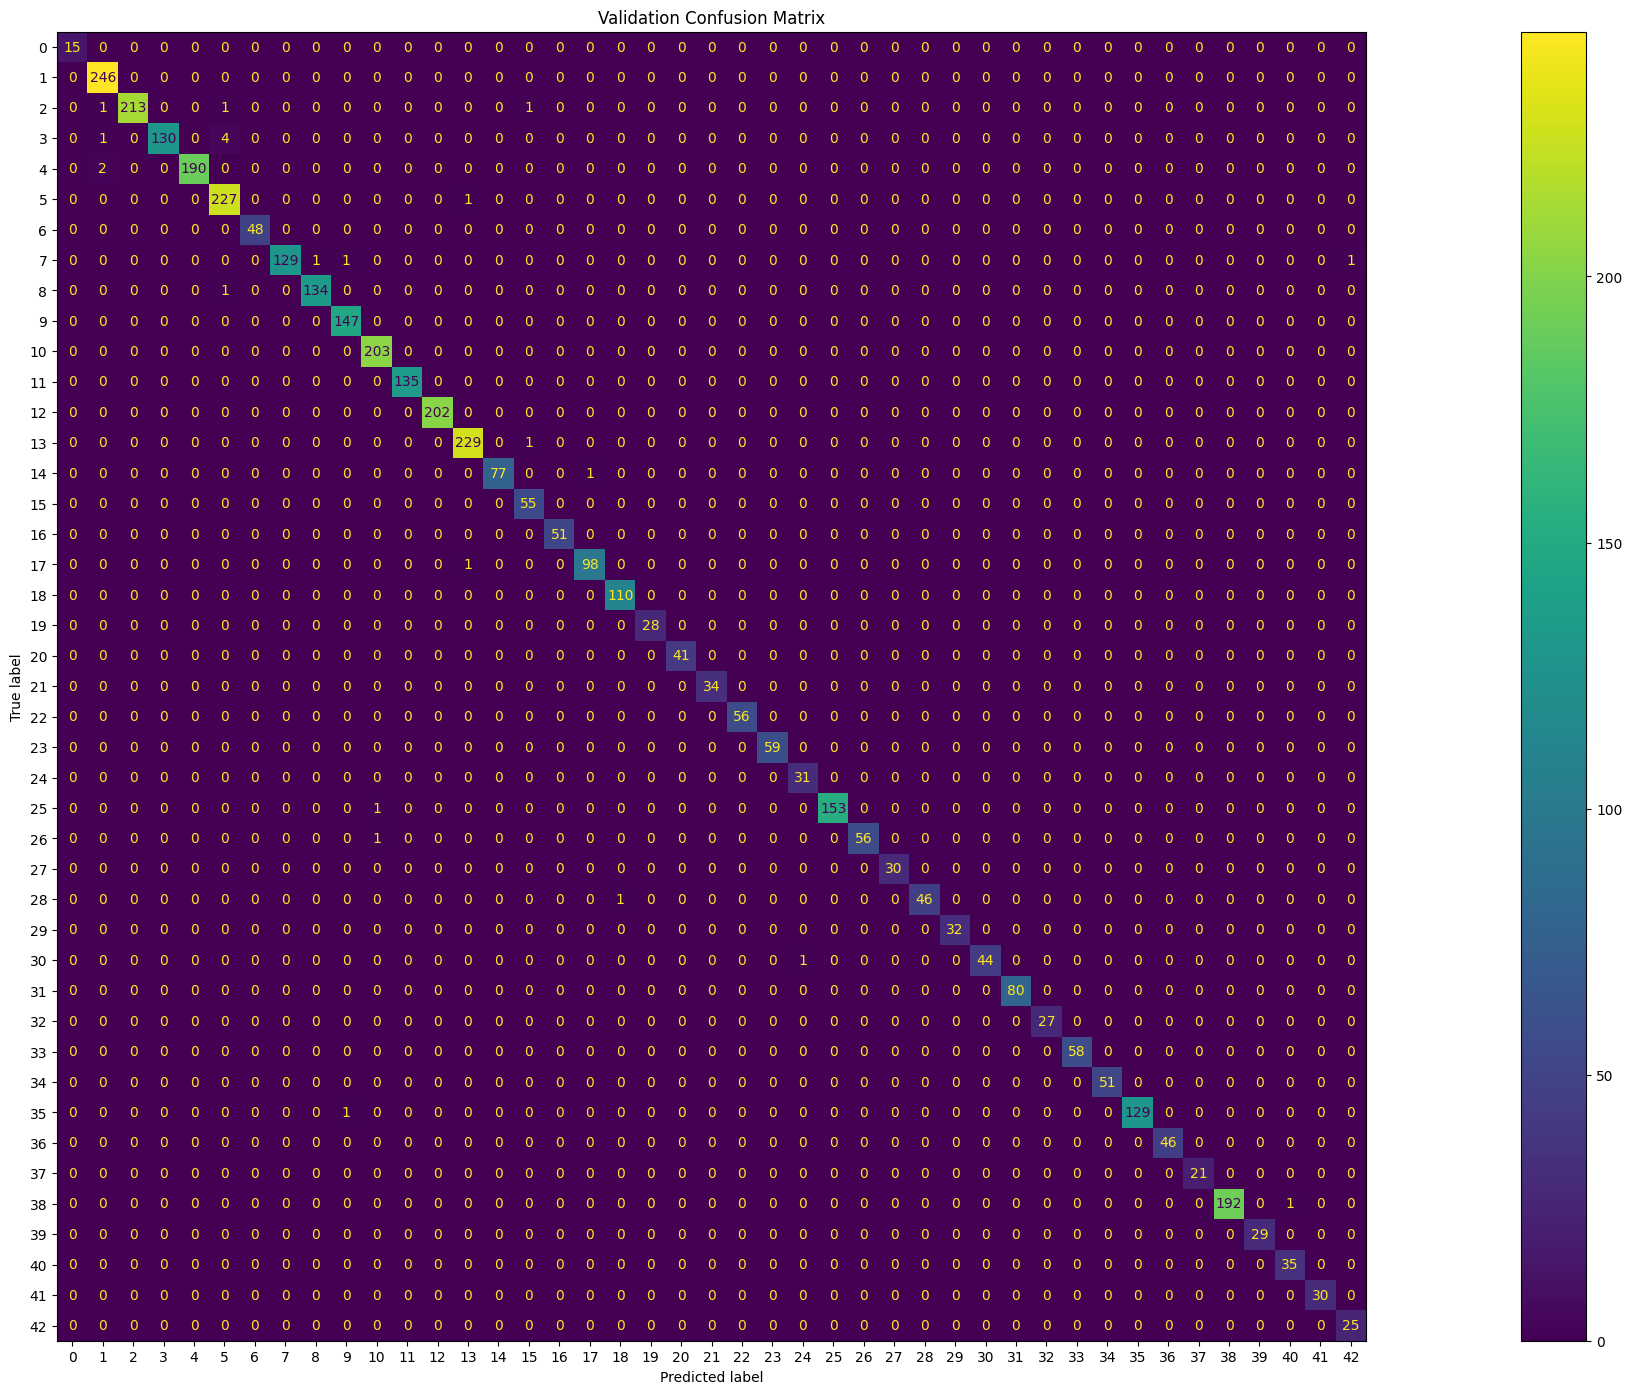

In [29]:
# Confusion matrix de la validació

predict_xValid = model.predict(X_valid)
classes_xValid = np.argmax(predict_xValid,axis=1)
yValid_true = np.argmax(y_valid, axis=1)

valid_confusion_matrix = metrics.confusion_matrix(yValid_true, classes_xValid)

valid_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = valid_confusion_matrix)

fig, ax = plt.subplots(figsize=(40, 17)) 
valid_cm_display.plot(ax=ax)
ax.set_title('Validation Confusion Matrix')

plt.show()

**Conclusions:** 

- Els elements colorits en diagonal són els resultats predits correctament. És a dir, que un total de 3972 prediccions han estat correctes sobre 3996 exemples de validació. Això resulta en un **99,4% d'accuracy**. Lògicament, l'accuracy de la validació és lleugerament més baix al de l'entrenament.

- En aquest cas hi ha alguna classe més que té prediccions incorrectes. Tanmateix, que en tinguin més d'una trobem les classes 1, 5, 9, 10, 13, i 15.

- La classe que té més prediccions incorrectes és la 5 (que resulta ser el senyal de ['límit de velocitat de 80 Km/h'](Noms_senyals.csv)), amb 6 prediccions incorrectes i, per tant, un accuracy del 97,42%. 

- D'altra banda, la classe 3 (['límit de velocitat de 60 Km/h'](Noms_senyals.csv)) sembla ser la més confusa, ja que el model l'ha confós 1 cop amb la classe 1 (['límit de velocitat de 30 Km/h'](Noms_senyals.csv)) i 4 cops amb la classe 5 (['límit de velocitat de 80 Km/h'](Noms_senyals.csv)). 

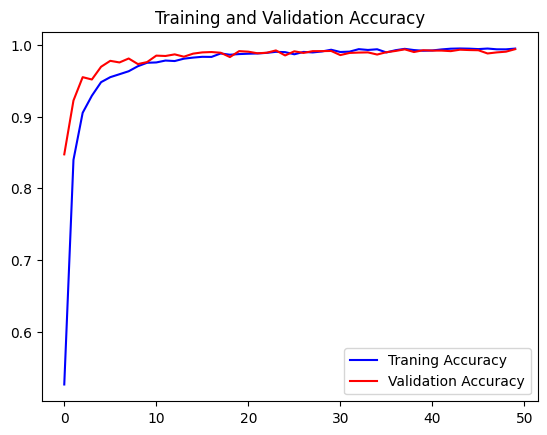

In [16]:
# Accuracy

train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

epochs = range(len(train_accuracy))
plt.plot(epochs, train_accuracy, 'b', label='Traning Accuracy')
plt.plot(epochs, valid_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

**Conclusions:**

- Com podem observar, l'accuracy no varia gaire entre l'entrenament i la validació, tal i com hem pogut deduir a partir de les Confusion Matrix. 

- També podem veure com de ràpid el model arriba al seu millor rendiment. Veiem que el rendiment s'estabilitza cap als 5 epochs. Per tant, hem fet bé d'aturar-nos als 50 epochs i no abans, ja que li hem donat suficient temps al model per aconseguir un rendiment estable.

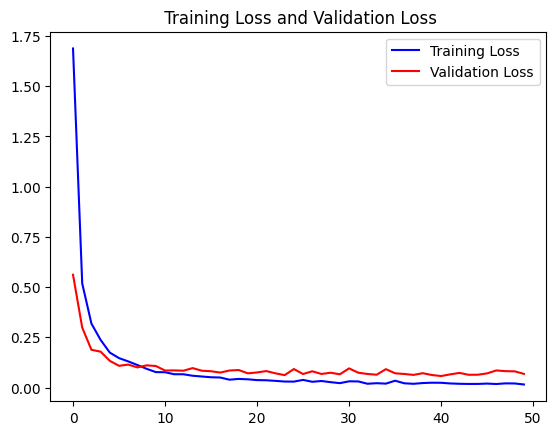

In [17]:
# Loss

train_loss = history.history['loss']
valid_loss = history.history['val_loss']

epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, valid_loss, 'r', label='Validation Loss')
plt.title(' Training Loss and Validation Loss')
plt.legend()

**Conclusions:**

- Efectivament, hem escollit correctament el nombre d'epochs (50) ja que les dues corves mostren una gran reducció del loss per llavors i arriben pràcticament a 0.

- Podem veure que el loss de la validació va lleugerament per sobre del de l'entrenament. És normal que passi i és realment poc, per tant, no és preocupant. Tanmateix, si hagués augmentat més, ens trobariem amb un problema de "Overfitting", perquè veuriem que el model no hauria estat capaç de generalitzar les dades noves de la validació. 

In [18]:
# Guardem el model a la carpeta "model"
model.save('./model/lenet.keras')

---
## Pas 6: Tornem a avaluar el model amb les imatges de prova

Un cop hem entrenat el model i hem avaluat els resultats d'aquest procés, podem comprovar el seu rendiment al donar-li les dades de prova, que havíem separat de la resta del dataset. Tot seguit, podem comparar el seu rendiment amb el que ha mostrat durant l'entrenament.

Per fer això, tindrem en compte diferents gràfiques. Tindrem en compte l'**accuracy** i el **loss** que ha obtingut el model amb els diferents conjunts de dades i en diferents moments (entrenament, validació i prova), els valors dels quals mostrarem i, tot seguit, compararem entre sí en una gràfica de barres.

84/84 - 0s - 5ms/step - accuracy: 0.9921 - loss: 0.0827
625/625 - 1s - 2ms/step - accuracy: 0.9998 - loss: 7.2497e-04
125/125 - 0s - 2ms/step - accuracy: 0.9940 - loss: 0.0678

Training accuracy: 0.9997997879981995

Validation accuracy: 0.9939939975738525

Test accuracy: 0.9921171069145203


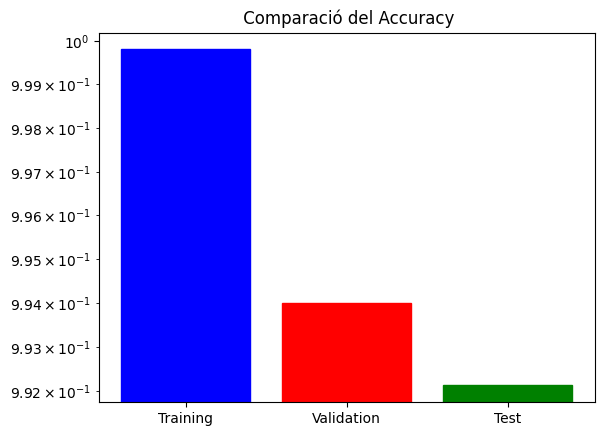


Training loss: 0.0007249735645018518

Validation loss: 0.06779587268829346

Test loss: 0.08269353210926056


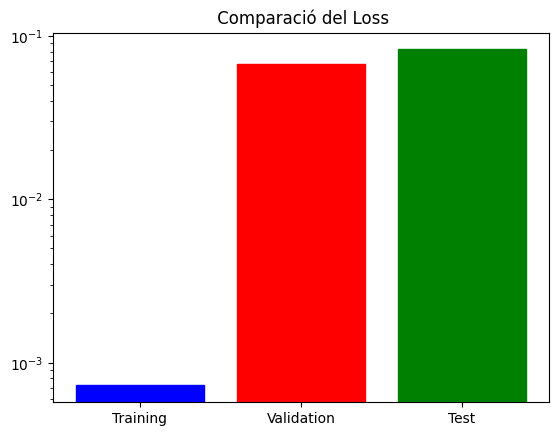

In [19]:
model = load_model('./model/lenet.keras') # Carreguem el model

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2) # Avaluem les noves dades de prova
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2) # Avaluem l'entrenament
valid_loss, valid_acc = model.evaluate(X_valid, y_valid, verbose=2) # Avaluem la validació

# Accuracy

    # Mostrem els valors
print('\nTraining accuracy:', train_acc)
print('\nValidation accuracy:', valid_acc)
print('\nTest accuracy:', test_acc)

    # Els comparem amb una gràfica
x_acc = np.array(["Training", "Validation", "Test"]) # Les diferents columnes o barres
y_acc = np.array([train_acc, valid_acc, test_acc]) # Els seus valors corresponents
bars_acc = plt.bar(x_acc,y_acc) # Creem el gràfic
plt.yscale('log') # Canviem l'escala de l'eix Y per apreciar millor els diferents valors
plt.title(' Comparació del Accuracy')
bars_acc[0].set_color('blue')
bars_acc[1].set_color('red')
bars_acc[2].set_color('green')
plt.show()

# Loss

    # Mostrem els valors
print('\nTraining loss:', train_loss)
print('\nValidation loss:', valid_loss)
print('\nTest loss:', test_loss)

    # Els comparem amb una gràfica
x_loss = np.array(["Training", "Validation", "Test"])
y_loss = np.array([train_loss, valid_loss, test_loss])
bars_loss = plt.bar(x_loss,y_loss)
plt.yscale('log')
plt.title(' Comparació del Loss')
bars_loss[0].set_color('blue')
bars_loss[1].set_color('red')
bars_loss[2].set_color('green')
plt.show()

# Guardem el model a la carpeta "model"
model.save('./model/lenet.keras')

**Conclusions:**

- És normal que l'accuracy sigui més baix en el test que en l'entrenament. Com podem observar, els valors no canvien gaire. A les gràfiques sembla una gran diferència però és causa de l'escala de l'eix Y.

- El mateix s'aplica en l'augment del loss. 

---
## Pas 7: Provem el model en imatges completament noves

Per comprovar si realment tenim un model funcional, prenem unes imatges completament noves que es troben a la carpeta [mysigns](mysigns) i les passem pel model, que ens ha de dir quina classe de senyal de trànsit contenen.

In [20]:
import pandas as pd

# Per fer-ho més visual, prendrem com a etiquetes la llista de noms que es troba en el fitxer "noms_senyals.csv"
input = pd.read_csv("Noms_senyals.csv")
class_names = input.nom

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


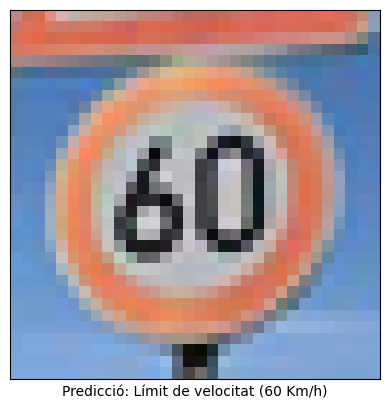

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


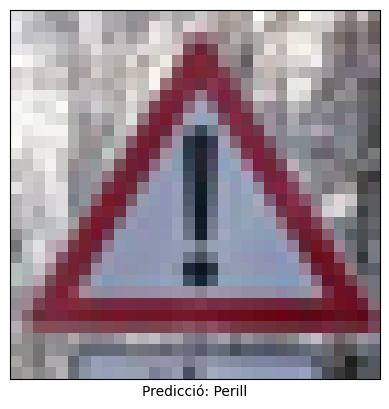

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


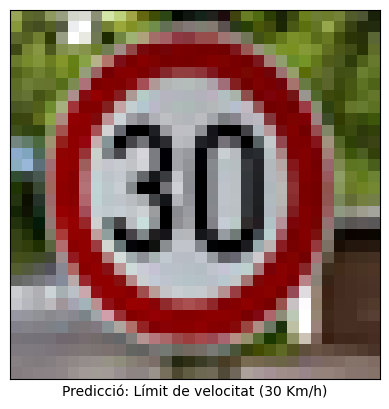

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


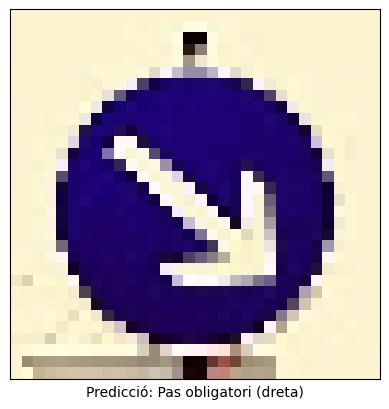

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


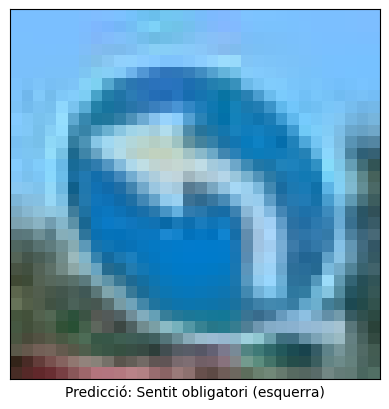

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


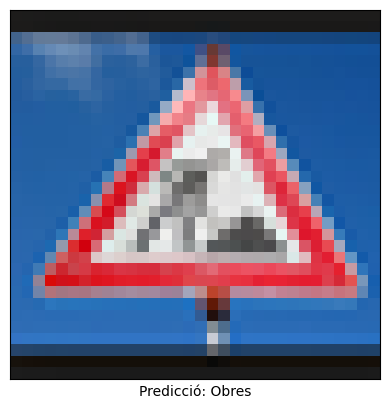

In [21]:
model = load_model('./model/lenet.keras') # Carreguem el model

my_images_path = './mysigns/'
my_images_folder = os.listdir(my_images_path)

for file_name in my_images_folder:
    img = cv.imread(my_images_path + file_name)
    img = cv.resize(img, (32, 32))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = np.array(img)

    img = img.astype(np.int16)
    img = normalize(img) # Normalitzem aquestes imatges noves

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    img = img.reshape(1, 32, 32, 3)
    pred = model.predict(img)   # El model fa les prediccions
    pred_class = np.argmax(pred)
    pred_label = class_names[pred_class]

    plt.xlabel('Predicció: ' + pred_label)
    plt.show() # Mostrem els resultats